# Earthquake damage classification

## 07 March 2020, Mw5.3 Zagreb Earthquake, Croatia 🇭🇷

## 0: Preliminaries

### Import python libraries 

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import fiona
import folium
import rasterio
import rasterio.mask
import rasterstats as rs
import seaborn as sns
from shapely.geometry import Point
from time import time
import matplotlib.pyplot as plt
%matplotlib inline
starttime = time()

/Users/anirudh/GEM/Code/venvs/horus/lib/python3.9/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


### Set the default coordinate reference system

In [2]:
dst_crs = "EPSG:4326"

### Indicate paths to input files

In [3]:
event_name = "M5.3 Zagreb Earthquake, Croatia"
dpm_raw_file = "DPM/ARIA_DPM2raw_Sentinel-1_T146_v0.8.tif"
dpm_clipped_file = "DPM/ARIA_DPM2raw_Sentinel-1_T146_v0.8_ShakeMapMask.tif" # generated below, not an input
building_footprints_file = "Buildings/Buildings.geojson"
damage_labels_file = "zip://DamageLabels/Procjena_zgrada_Zagreb.zip"
shakemap_url = "https://earthquake.usgs.gov/product/shakemap/us70008dx7/us/1585828759395/download/"
shakemap_json = shakemap_url + "cont_mmi.json" # Contours
shakemap_zip = shakemap_url + "shape.zip" # Polygons

## 1: Demarcate affected area

### Draw an empty map centered on the event¶

In [4]:
lat = +45.85
lon = +16.03

bound_n = +46.8
bound_e = +17.3
bound_s = +45.0
bound_w = +14.7

m = folium.Map(
    location=[lat, lon], 
    zoom_start=10,
    tiles='Stamen Terrain')

folium.CircleMarker(
    location=[lat, lon],
    radius=5,
    tooltip="Epicenter",
    popup=event_name,
    color="IndianRed",
    fill_color="LightCoral",
    fill=True
).add_to(m)

m

### Draw ShakeMap contours for MMI ≥ V

In [5]:
style_function = lambda x: {
    'color': x["properties"]["color"],
    'weight': x["properties"]["weight"] if x["properties"]["value"] >= 5 else 0
}
tooltip = folium.features.GeoJsonTooltip(fields=["value"])

folium.GeoJson(
    shakemap_json,
    name="ShakeMap Contours",
    style_function=style_function,
    tooltip=tooltip
).add_to(m)

folium.TileLayer('OpenStreetMap').add_to(m)
folium.LayerControl().add_to(m)

m

### Save the MMI V contour as a vector layer

In [6]:
shakemap_gdf = gpd.read_file(shakemap_json)
shakemapV_gdf = shakemap_gdf[shakemap_gdf.value==5]
shakemapV_gdf.to_file("ShakeMap/MMI_V_Contours.gpkg", driver="GPKG")
shakemapV_gdf.convex_hull.to_file("ShakeMap/MMI_V_Envelope.gpkg", driver="GPKG")

## 2: Load DPM tiles and mask to built areas within MMI≥V

### Read the DPM raster and mask it using the MMI V contour

In [7]:
from rasterio.warp import calculate_default_transform, reproject, Resampling

with fiona.open("ShakeMap/MMI_V_Envelope.gpkg", "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]

with rasterio.open(dpm_raw_file) as src:
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
    out_meta = src.meta
    
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with rasterio.open(dpm_clipped_file, "w", **out_meta) as dest:
    dest.write(out_image)

### Explore the distribution of the clipped DPM pixel values by plotting a histogram¶

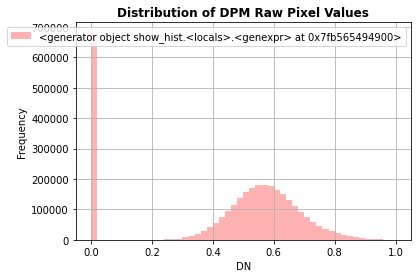

In [8]:
from rasterio.plot import show_hist
dpm_src = rasterio.open(dpm_clipped_file)
show_hist(
    dpm_src, bins=50, lw=0.0, stacked=False, alpha=0.3,
    histtype='stepfilled', title="Distribution of DPM Raw Pixel Values")

## 3: Load and plot the building inventory files

### Load the building inventory file for Zagreb 

In [9]:
bldgs_gdf = gpd.read_file(building_footprints_file)

### Inspect the building inventory file

In [10]:
bldgs_gdf.head()

,fid,ObjectType,Area,PROMJENA,layer,geometry
0,1,3,31,NaN,Commercial Buildings,"MULTIPOLYGON (((16.13108 45.82392, 16.13118 45..."
1,2,3,67,NaN,Commercial Buildings,"MULTIPOLYGON (((16.01324 45.81940, 16.01323 45..."
2,3,3,120,NaN,Commercial Buildings,"MULTIPOLYGON (((16.01320 45.81938, 16.01310 45..."
3,4,3,250,NaN,Commercial Buildings,"MULTIPOLYGON (((16.13106 45.82393, 16.13116 45..."
4,5,3,883,NaN,Commercial Buildings,"MULTIPOLYGON (((16.02054 45.81869, 16.02041 45..."


### Drop unnecessary columns

In [11]:
bldgs_gdf.drop(columns=["fid", "ObjectType", "PROMJENA"], inplace=True)

## 4: Join the damage labels to the building inventory

### Load the damage labels ("ground truth" / "test labels")

In [12]:
dmg_labels_gdf = gpd.read_file(damage_labels_file)

### Inspect the damage labels layer contents

In [13]:
dmg_labels_gdf.head()

,OBJECTID,Broj_obras,Adresa,Post_br,Naselje,Gradska_ce,Mjesni_odb,NAZIV_LOKA,PRIJAVIO,Ime_prezim,...,Kontrola_q,Hitnost,Kontrola_a,Veza,Namjena,Sekundarne,Spomenik_k,Oznaka,Status_zau,geometry
0,2,2,Gundulićeva 35,10000,Zagreb,None,None,"Pov.urb.cjelina, Z-1525",None,None,...,PRIKAZUJE SE,0,Gundulićeva ulica 35,None,13 Stambena,None,Da,None,None,POINT Z (1778033.395 5749709.770 0.000)
1,7,7,ILICA 38,10000,Zagreb,None,None,None,None,None,...,PRIKAZUJE SE,0,Ilica 38,None,None,None,None,None,None,POINT Z (1777877.069 5750491.158 0.000)
2,8,8,ILICA 115,10000,Zagreb,None,None,None,None,None,...,PRIKAZUJE SE,0,Ilica 115,None,None,None,None,None,None,POINT Z (1776540.433 5750436.898 0.000)
3,9,9,ILICA123,10000,Zagreb,None,None,None,None,None,...,"PRIKAZUJE SE, PREMJEŠTENA",0,None,#ILICA123#23.03.2020#,None,None,None,None,None,POINT Z (1776082.575 5750400.302 0.000)
4,12,12,Petrinjska 12,10000,Zagreb,None,None,Županijski sud u Zagrebu (većinski dio) i Trgo...,None,None,...,"PRIKAZUJE SE, PREMJEŠTENA",0,None,#Petrinjska#23.03.2020#,None,None,None,None,None,POINT Z (1778857.731 5750106.106 0.000)


In [14]:
# Drop unnecessary columns
dmg_labels_gdf = dmg_labels_gdf[["Broj_katov", "Detaljno_u", "geometry"]]

# Translate field names to English
dmg_labels_gdf.rename(columns={"Broj_katov": "NUM_FLOORS", "Detaljno_u": "DAMAGE_GRADE"}, inplace=True)

# Inspect contents of the revised files
dmg_labels_gdf.head()

,NUM_FLOORS,DAMAGE_GRADE,geometry
0,4,PN2,POINT Z (1778033.395 5749709.770 0.000)
1,6,U1,POINT Z (1777877.069 5750491.158 0.000)
2,2,PN2,POINT Z (1776540.433 5750436.898 0.000)
3,4,U1,POINT Z (1776082.575 5750400.302 0.000)
4,3,U2,POINT Z (1778857.731 5750106.106 0.000)


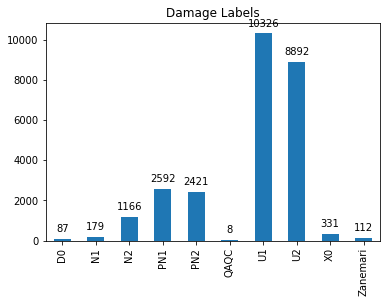

In [15]:
# Inspect the damage grade labels column
ax = (dmg_labels_gdf.DAMAGE_GRADE
      .value_counts()
      .sort_index()
      .plot.bar(
          title="Damage Labels"
      ))
for p in ax.patches:
    ax.annotate(
        p.get_height(), (p.get_x()+p.get_width()/2., p.get_height()), 
        ha='center', va='center', 
        xytext=(0, 10), textcoords='offset points')

### Explanation of damage labels
N1 - Unusable - due to external influence - The building is risk due to the possibility of collapse of massive parts of an adjacent building. Due to such danger, it is recommended not to stay in such buildings.

N2 - Unusable - due to damage - The building is at risk due to the possibility of collapse of massive parts of the damaged building. Due to such a danger, it is recommended not to stay in such buildings (especially given the large number of earthquake recurrences).

PN1 - Temporarily unusable (in whole or in part) - detailed inspection required. The building has moderate damage with no danger of collapsing. The load-bearing capacity of the building is partially impaired. It is not recommended to stay in the building, ie citizens stay in such a building at their own risk. A shorter stay in the building is possible, with the advice of a construction expert regarding the necessary measures and restriction of stay. A construction expert makes recommendations to eliminate the hazards.

PN2 - Temporarily unusable - necessary emergency intervention measures (maybe usable after short-term interventions). The building has moderate damage without the danger of collapsing entirely, but it cannot be used due to the potential danger of collapse of certain elements of the building. A structural expert will identify emergency intervention measures and will give instructions to the occupants. Until the measures are implemented, the building or part of it is not usable (for example the roof). Temporary unusability can only apply to some parts (units) of the building.

U1 - Usable without restrictions - The building can be used. The building has no damage or has little damage that does not pose a danger to the load-bearing capacity and usability of the building.

U2 - Usable with recommendation - the building may be used in accordance with its intended purpose, except in certain parts where there is an immediate danger to a part of the building. The construction expert gives recommendations for the removal of hazards and recommendations to users for temporary restriction of residence in certain parts of the building. Once the danger has been removed, the building can be used without restrictions.

### Treatment of damage labels for this study
* D0, QAQC, X0, Zanemari – D0: "No Damage"
* U1, U2 – D1: "Slight Damage"
* PN1, PN2 – D2: "Moderate Damage"
* N1, N2 – D3: "Heavy Damage"

### Relabel damage grades for use in the training and testing module with integer values

In [16]:
dmg_labels_gdf.replace(
    to_replace={"DAMAGE_GRADE":{
        "D0": "0", "QAQC": "0", "X0": "0", "Zanemari": "0",
        "U1": "1", "U2": "1",
        "PN1": "2", "PN2": "2",
        "N1": "3", "N2": "3"}},
    inplace=True)

# Inspect the damage grades database
dmg_labels_gdf.head()

,NUM_FLOORS,DAMAGE_GRADE,geometry
0,4,2,POINT Z (1778033.395 5749709.770 0.000)
1,6,1,POINT Z (1777877.069 5750491.158 0.000)
2,2,2,POINT Z (1776540.433 5750436.898 0.000)
3,4,1,POINT Z (1776082.575 5750400.302 0.000)
4,3,1,POINT Z (1778857.731 5750106.106 0.000)


### Inspect the damage grade labels column after the relabeling

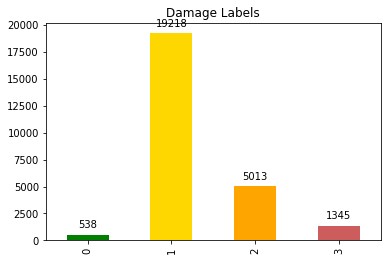

In [17]:
ax = (dmg_labels_gdf.DAMAGE_GRADE
      .value_counts()
      .sort_index()
      .plot.bar(
          title="Damage Labels",
          color=["Green", "Gold", "Orange", "IndianRed"],
      ))
for p in ax.patches:
    ax.annotate(
        p.get_height(), (p.get_x()+p.get_width()/2., p.get_height()), 
        ha='center', va='center', 
        xytext=(0, 10), textcoords='offset points')

In [18]:
# Inspect the coordinate reference system used by the damage database
dmg_labels_gdf.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [19]:
# Reproject the damage dataset to the project coordinate reference system
dmg_labels_gdf = dmg_labels_gdf.to_crs(dst_crs)

### Join the damage labels to the building inventory

In [20]:
# Create a buffered polygon layer from the buildings layer
bldgs_buffer_gdf = bldgs_gdf.copy()

# Buffer each building footprint using a 5 meter buffer zone 
# and replace the original geometry with the new buffered geometry
bldgs_buffer_gdf["geometry"] = bldgs_gdf.to_crs("EPSG:3857").buffer(5).to_crs(dst_crs)
bldgs_buffer_gdf.head()

,Area,layer,geometry
0,31,Commercial Buildings,"POLYGON ((16.13104 45.82393, 16.13105 45.82394..."
1,67,Commercial Buildings,"POLYGON ((16.01325 45.81937, 16.01324 45.81937..."
2,120,Commercial Buildings,"POLYGON ((16.01321 45.81935, 16.01311 45.81933..."
3,250,Commercial Buildings,"POLYGON ((16.13105 45.82390, 16.13104 45.82390..."
4,883,Commercial Buildings,"POLYGON ((16.02050 45.81868, 16.02050 45.81868..."


In [21]:
# Intersect the damage label points with the bufferered building footprint polygons
tic = time()
input_gdf = gpd.sjoin(
    bldgs_buffer_gdf,
    dmg_labels_gdf,
    how="left",
    op="contains")
print(f"Spatial join completed in {time() - tic:.0f}s")

Spatial join completed in 3s


In [22]:
# Assign buildings with no damage label to "No damage"
input_gdf.rename(columns={"DMG_GRADE_max": "DAMAGE_GRADE"}, inplace=True)
input_gdf.fillna(value={"DAMAGE_GRADE": "0"}, inplace=True)

In [23]:
# Drop unused columns and inspect the newly joined database
input_gdf.drop(columns=["index_right", "NUM_FLOORS"], inplace=True)
input_gdf.head()

,Area,layer,geometry,DAMAGE_GRADE
0,31,Commercial Buildings,"POLYGON ((16.13104 45.82393, 16.13105 45.82394...",0
1,67,Commercial Buildings,"POLYGON ((16.01325 45.81937, 16.01324 45.81937...",0
2,120,Commercial Buildings,"POLYGON ((16.01321 45.81935, 16.01311 45.81933...",0
3,250,Commercial Buildings,"POLYGON ((16.13105 45.82390, 16.13104 45.82390...",0
4,883,Commercial Buildings,"POLYGON ((16.02050 45.81868, 16.02050 45.81868...",0


### Inspect the damage grade labels column after the join

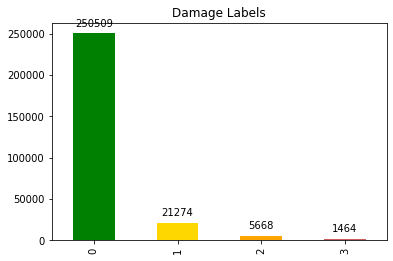

In [24]:
# We expect to see a lot more buildings in no damage
ax = (input_gdf.DAMAGE_GRADE
      .astype(int)
      .value_counts()
      .sort_index()
      .plot.bar(
          title="Damage Labels",
          color=["Green", "Gold", "Orange", "IndianRed"],
      ))
for p in ax.patches:
    ax.annotate(
        p.get_height(), (p.get_x()+p.get_width()/2., p.get_height()), 
        ha='center', va='center', 
        xytext=(0, 10), textcoords='offset points')

#### Note: This is an imbalanced dataset
The number of samples in Damage Grade "0" is roughly two orders of magnitude larger than the number of samples in Damage Grade "3". Most machine learning multiclass classification algorithms assume that all classes have roughly similar numbers of examples.

To circumvent this issue, one potential route is to modify the training set to have similar numbers of examples in each category, for instance by oversampling training examples from the classes with fewer examples.

Another route is to modify the classification algorithm by changing the way learning is performed, preferably biasing more towards those classes that have fewer examples in the training dataset. This is generally called cost-sensitive learning.

## 5. Join ShakeMap intensity to building inventory

### Join ShakeMap value to the building inventory

In [25]:
# Build url for the ShakeMap polygons shapefile and perform a spatial join
tic = time()
shakemap_shp = f"zip+{shakemap_zip}!mi.shp"
shakemap_gdf = gpd.read_file(shakemap_shp)
inputs_gdf = gpd.sjoin(input_gdf, shakemap_gdf, how="left", op="within")
print(f"Spatial join completed in {time() - tic:.0f}s")

Spatial join completed in 27s


In [26]:
# Drop unneeded columns and rename the remaining ones
inputs_gdf.drop(columns=["index_right", "AREA", "PERIMETER", "PGAPOL_", "PGAPOL_ID", "GRID_CODE"], inplace=True)
inputs_gdf.rename(columns={"Area": "AREA", "layer": "BLDG_TYPE", "PARAMVALUE": "MMI"}, inplace=True)

In [27]:
# Assign buildings with no shaking intensity to a value of MMI=0
inputs_gdf.fillna(value={"MMI": 0}, inplace=True)

In [28]:
# Create both string and numeric versions of the shaking intensity vector
inputs_strings = inputs_gdf.astype({"MMI": str, "DAMAGE_GRADE":str})
inputs_numeric = inputs_gdf.astype({"MMI": float, "DAMAGE_GRADE":int})

In [29]:
# Inspect the joined dataset
inputs_numeric.head()

,AREA,BLDG_TYPE,geometry,DAMAGE_GRADE,MMI
0,31,Commercial Buildings,"POLYGON ((16.13104 45.82393, 16.13105 45.82394...",0,6.0
1,67,Commercial Buildings,"POLYGON ((16.01325 45.81937, 16.01324 45.81937...",0,6.8
2,120,Commercial Buildings,"POLYGON ((16.01321 45.81935, 16.01311 45.81933...",0,6.8
3,250,Commercial Buildings,"POLYGON ((16.13105 45.82390, 16.13104 45.82390...",0,6.0
4,883,Commercial Buildings,"POLYGON ((16.02050 45.81868, 16.02050 45.81868...",0,6.6


/Users/anirudh/GEM/Code/venvs/horus/lib/python3.9/site-packages/seaborn/relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


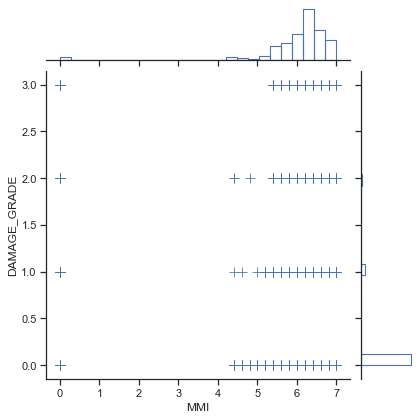

In [30]:
sns.set_theme(style="ticks")
sns.jointplot(
    data=inputs_numeric, 
    x="MMI", y="DAMAGE_GRADE", 
    marker="+", s=100, 
    marginal_kws=dict(bins=25, fill=False),
)

## 6: Join DPM values to the input dataset

### Find the maximum DPM value falling within each buffered building polygon

In [31]:
# This step can take several minutes, depending on the sizes
# of the building inventory + damage database and the DPM raster
tic = time()
with rasterio.open(dpm_clipped_file) as dpm_src:
    dpm_data = dpm_src.read(1, masked=True)
    dpm_meta = dpm_src.profile
    
inputs_list = rs.zonal_stats(
    inputs_numeric,
    dpm_data,
    nodata=-999,
    affine=dpm_meta['transform'],
    geojson_out=True,
    copy_properties=True,
    stats="max")

print(f"Zonal stats query completed in {time() - tic:.0f}s")

# View object type
type(inputs_list)

Zonal stats query completed in 408s


list

### Create dataframe with input variable values and labels

In [32]:
inputs_gdf = gpd.GeoDataFrame.from_features(inputs_list)
inputs_gdf.rename(columns={"max": "DPM_MAX"}, inplace=True)
inputs_gdf.head()

,geometry,AREA,BLDG_TYPE,DAMAGE_GRADE,MMI,DPM_MAX
0,"POLYGON ((16.13104 45.82393, 16.13105 45.82394...",31,Commercial Buildings,0,6.0,NaN
1,"POLYGON ((16.01325 45.81937, 16.01324 45.81937...",67,Commercial Buildings,0,6.8,NaN
2,"POLYGON ((16.01321 45.81935, 16.01311 45.81933...",120,Commercial Buildings,0,6.8,NaN
3,"POLYGON ((16.13105 45.82390, 16.13104 45.82390...",250,Commercial Buildings,0,6.0,0.509686
4,"POLYGON ((16.02050 45.81868, 16.02050 45.81868...",883,Commercial Buildings,0,6.6,0.614320


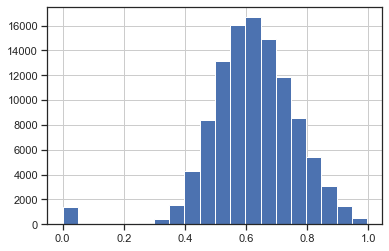

In [33]:
# Plot a histogram of the joined DPM values
# This ignores NaN values, i.e., those buildings for which no DPM value was assigned
dpm_hist = inputs_gdf.DPM_MAX.hist(bins=20)

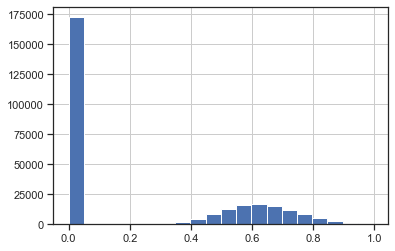

In [34]:
# Assign buildings with no DPM value to a value of DPM=0
inputs_gdf.fillna(value={"DPM_MAX": 0}, inplace=True)
dpm_hist = inputs_gdf.DPM_MAX.hist(bins=20)

## 7: Extract and explore the training features and training labels

### Extract the training labels and values as vectors

In [35]:
train_values = inputs_gdf[["MMI", "DPM_MAX"]]
train_labels = inputs_gdf[["DAMAGE_GRADE"]]

In [36]:
train_values.dtypes

MMI        float64
DPM_MAX    float64
dtype: object

In [37]:
train_labels.dtypes

DAMAGE_GRADE    int64
dtype: object

### Explore the training data

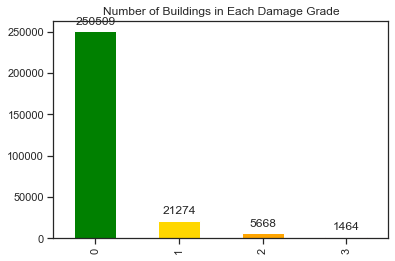

In [38]:
ax = (train_labels.DAMAGE_GRADE
      .value_counts()
      .sort_index()
      .plot.bar(
          title="Number of Buildings in Each Damage Grade",
          color=["Green", "Gold", "Orange", "IndianRed"],
      ))
for p in ax.patches:
    ax.annotate(
        p.get_height(), (p.get_x()+p.get_width()/2., p.get_height()), 
        ha='center', va='center', 
        xytext=(0, 10), textcoords='offset points')

### Select subset of features to use for training

In [39]:
selected_features = ["MMI", "DPM_MAX"]
train_values_subset = train_values[selected_features]

### Explore the relationships between the numeric features and labels

/Users/anirudh/GEM/Code/venvs/horus/lib/python3.9/site-packages/seaborn/relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('1').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


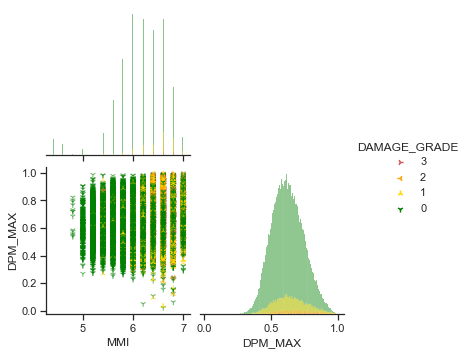

In [40]:
sns.set_theme(style="ticks")
train_values_subset_plot = train_values_subset.replace(0, np.nan)
sns.pairplot(
    train_values_subset_plot.join(train_labels),
    hue="DAMAGE_GRADE",
    hue_order=[3, 2, 1, 0],
    palette={0:"Green", 1:"Gold", 2:"Orange", 3:"IndianRed"},
    markers=["1", "2", "3", "4"],
    kind="scatter",
    diag_kind="hist",
    corner=True,
    plot_kws={'alpha':0.6, 'linewidth':1},
    diag_kws={'fill':True},
    grid_kws={'diag_sharey':False},
)

/Users/anirudh/GEM/Code/venvs/horus/lib/python3.9/site-packages/seaborn/relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('2').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


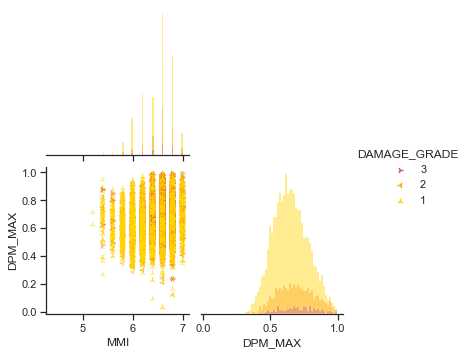

In [41]:
# Ignore Damage Grade 0 for the plots
sns.pairplot(
    train_values_subset_plot.join(train_labels).replace(0, np.nan),
    hue="DAMAGE_GRADE",
    hue_order=[3, 2, 1],
    palette={1:"Gold", 2:"Orange", 3:"IndianRed"},
    markers=["2", "3", "4"],
    kind="scatter",
    diag_kind="hist",
    corner=True,
    plot_kws={'alpha':0.6, 'linewidth':1},
    diag_kws={'fill':True},
    grid_kws={'diag_sharey':False},
)

## 8: Build the ML model(s)

### Import modules for the machine learning training component

In [42]:
# for preprocessing the data
from sklearn.preprocessing import StandardScaler

# for splitting the data into training and test sets
from sklearn.model_selection import train_test_split

# the model(s)
from sklearn.ensemble import RandomForestClassifier

# for combining the preprocess with model training
from sklearn.pipeline import make_pipeline

# for optimizing the hyperparameters of the pipeline
from sklearn.model_selection import GridSearchCV

### Split dataset into training and test subsets

When performing a (supervised) machine learning experiment, it is common to hold out part of the available data as a test set `X_test, y_test`. The best parameters can be determined by grid search techniques.

In [43]:
X_train, X_test, y_train, y_test = train_test_split(train_values_subset, train_labels, train_size=0.70, test_size=0.30, random_state=40)

### Use a Random Forest Classifier with class weights

In [44]:
pipe = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(
        random_state=42,
        max_depth=None,
        min_samples_split=2,
        max_features="sqrt",
        class_weight="balanced"
    )
)
pipe

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced',
                                        max_features='sqrt',
                                        random_state=42))])

### Train a random forest model with different parameters using grid search

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

In [45]:
param_grid = {'randomforestclassifier__n_estimators': [50, 100],
              'randomforestclassifier__min_samples_leaf': [1, 5]}
gs = GridSearchCV(pipe, param_grid, cv=5)

In [46]:
tic = time()
gs.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(class_weight='balanced',
                                                               max_features='sqrt',
                                                               random_state=42))]),
             param_grid={'randomforestclassifier__min_samples_leaf': [1, 5],
                         'randomforestclassifier__n_estimators': [50, 100]})

In [47]:
print(f"Model fit completed in {time() - tic:.0f}s")

Model fit completed in 1514s


### Model with the best parameters

In [48]:
gs.best_params_

{'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__n_estimators': 50}

### Evaluate the model prediction performance on the _training set_

In [49]:
# Evaluation metrics
# from sklearn.metrics import roc_curve # restricted to the binary classification case
# from sklearn.metrics import plot_precision_recall_curve # restricted to the binary classification case
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score

#### Compute the F1 score, also known as balanced F-score or F-measure for the _training_ set

The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:

`F1 = 2 * (precision * recall) / (precision + recall)`

In our multi-class case, this is the average of the F1 score of each class with weighting depending on the average parameter.

In [50]:
# Calculate metrics globally by counting the total true positives, 
# false negatives and false positives.
in_sample_preds = gs.predict(train_values_subset)
f1_score(train_labels, in_sample_preds, average='micro')

0.773160281806285

In [51]:
# Calculate metrics for each label, and find their average weighted 
# the number of true instances for each label. This alters ‘macro’ to 
# account for label imbalance; it can result in an F-score that is not 
# between precision and recall.
f1_score(train_labels, in_sample_preds, average='weighted')

0.8408319647242832

In [52]:
# Calculate metrics for each label, and find their unweighted mean. 
# This does not take label imbalance into account.
f1_score(train_labels, in_sample_preds, average='macro')

0.4612032864230263

#### Print balanced accuracy score for predictions on the _training_ set

The balanced_accuracy_score function computes the balanced accuracy, which avoids inflated performance estimates on imbalanced datasets. It is the macro-average of recall scores per class or, equivalently, raw accuracy where each sample is weighted according to the inverse prevalence of its true class. For balanced datasets, the score is equal to accuracy.

In [53]:
balanced_accuracy_score(train_labels, in_sample_preds)

0.6010307663296867

#### Print classification report for predictions on the _training_ set
The precision is the ratio `tp / (tp + fp)` where `tp` is the number of true positives and `fp` the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

The recall is the ratio `tp / (tp + fn)` where `tp` is the number of true positives and `fn` the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

In [54]:
target_names = ["No Damage", "Slight Damage", "Moderate Damage", "Heavy Damage"]
print(classification_report(train_labels, in_sample_preds, target_names=target_names))

                 precision    recall  f1-score   support

      No Damage       0.97      0.81      0.88    250509
  Slight Damage       0.72      0.45      0.55     21274
Moderate Damage       0.31      0.46      0.37      5668
   Heavy Damage       0.02      0.69      0.04      1464

       accuracy                           0.77    278915
      macro avg       0.51      0.60      0.46    278915
   weighted avg       0.93      0.77      0.84    278915



#### Display the confusion matrix for the predictions on the _training_ set

In [55]:
confusion_matrix(train_labels, in_sample_preds)

array([[202543,   3299,   4384,  40283],
       [  5406,   9491,   1257,   5120],
       [  1199,    294,   2601,   1574],
       [   316,     43,     94,   1011]])

#### Plot confusion matrix with absolute, non-normalized values

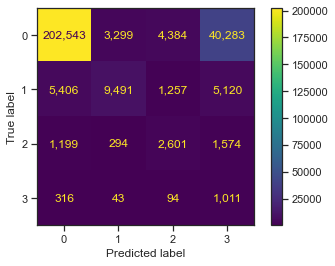

In [56]:
plot_confusion_matrix(
    gs, train_values_subset, train_labels,
    values_format=",",
    cmap="viridis"
)

#### Plot confusion matrix with normalized values

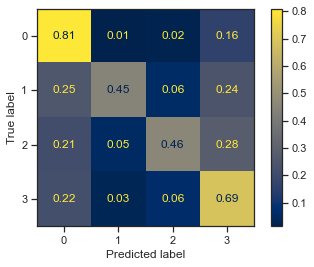

In [57]:
plot_confusion_matrix(
    gs, train_values_subset, train_labels,
    normalize="true",
    values_format=".2f",
    cmap="cividis"
)

### Partial Dependence and Individual Conditional Expectation

In [58]:
from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence

Done in 121s


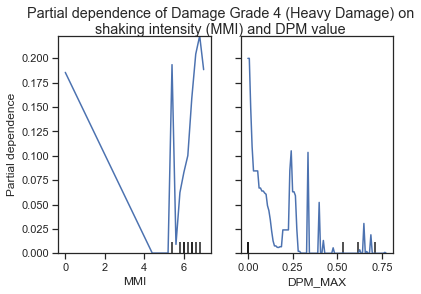

In [59]:
tic = time()
numeric_features = ["MMI", "DPM_MAX"]
display = plot_partial_dependence(
    gs, X_train, numeric_features, target=3, n_cols=2
)
print(f"Done in {time() - tic:.0f}s")
display.figure_.suptitle(
    'Partial dependence of Damage Grade 4 (Heavy Damage) on\n'
    'shaking intensity (MMI) and DPM value'
)
display.figure_.subplots_adjust(hspace=0.5)

## 9: Make predictions on the test set and evaluate the model performance

### Use the trained ML model to make predictions on the test set

In [60]:
y_pred = gs.predict(X_test)

### Evaluate the model prediction performance on the _test_ set

#### Display the confusion matrix for the predictions on the _test_ set

In [61]:
confusion_matrix(y_test, y_pred)

array([[59195,  2255,  1642, 12026],
       [ 2993,  1408,   489,  1541],
       [  662,   227,   330,   475],
       [  156,    41,    53,   182]])

#### Plot confusion matrix with absolute, non-normalized values

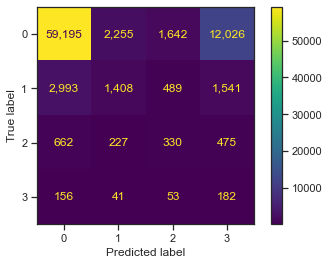

In [62]:
plot_confusion_matrix(
    gs, X_test, y_test,
    values_format=",",
    cmap="viridis"
)

#### Plot confusion matrix with normalized values

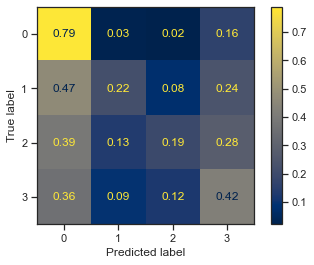

In [63]:
plot_confusion_matrix(
    gs, X_test, y_test,
    normalize="true",
    values_format=".2f",
    cmap="cividis"
)

#### Print classification report for the predictions on the _test_ set

In [64]:
target_names = ["No Damage", "Slight Damage", "Moderate Damage", "Heavy Damage"]
print(classification_report(y_test, y_pred, target_names=target_names))

                 precision    recall  f1-score   support

      No Damage       0.94      0.79      0.86     75118
  Slight Damage       0.36      0.22      0.27      6431
Moderate Damage       0.13      0.19      0.16      1694
   Heavy Damage       0.01      0.42      0.02       432

       accuracy                           0.73     83675
      macro avg       0.36      0.41      0.33     83675
   weighted avg       0.87      0.73      0.79     83675



#### Print balanced accuracy score for the predictions on the _test_ set

In [65]:
balanced_accuracy_score(y_test, y_pred)

0.4057669601541835

## 10: Try binary classification

### Compress the damage grades into 0 and 1

In [66]:
# Assign buildings with no DPM value to a value of DPM=0
inputs_gdf["DAMAGE_GRADE_BINARY"] = inputs_gdf.DAMAGE_GRADE.apply(lambda x: 0 if x<=1 else 1)

### Extract the training features and training labels

In [67]:
train_values = inputs_gdf[["MMI", "DPM_MAX"]]
train_labels = inputs_gdf[["DAMAGE_GRADE_BINARY"]]

In [68]:
train_values.dtypes

MMI        float64
DPM_MAX    float64
dtype: object

In [69]:
train_labels.dtypes

DAMAGE_GRADE_BINARY    int64
dtype: object

### Explore the training data

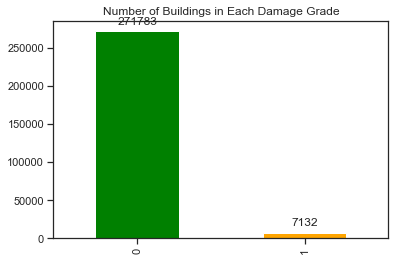

In [70]:
ax = (train_labels.DAMAGE_GRADE_BINARY
      .value_counts()
      .sort_index()
      .plot.bar(
          title="Number of Buildings in Each Damage Grade",
          color=["Green", "Orange"],
      ))
for p in ax.patches:
    ax.annotate(
        p.get_height(), (p.get_x()+p.get_width()/2., p.get_height()), 
        ha='center', va='center', 
        xytext=(0, 10), textcoords='offset points')

### Select subset of features to use for training

In [71]:
selected_features = ["MMI", "DPM_MAX"]
train_values_subset = train_values[selected_features]

### Explore the relationships between the numeric features and labels

/Users/anirudh/GEM/Code/venvs/horus/lib/python3.9/site-packages/seaborn/relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('1').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


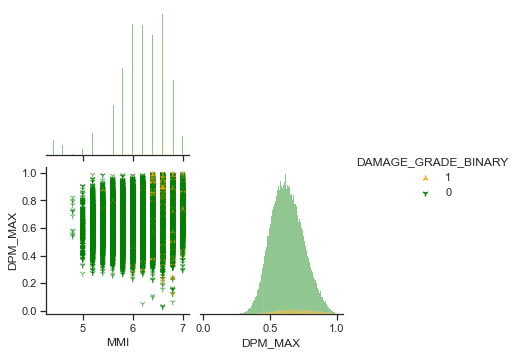

In [72]:
sns.set_theme(style="ticks")
train_values_subset_plot = train_values_subset.replace(0, np.nan)
sns.pairplot(
    train_values_subset_plot.join(train_labels),
    hue="DAMAGE_GRADE_BINARY",
    hue_order=[1, 0],
    palette={0:"Green", 1:"Orange"},
    markers=["1", "2"],
    kind="scatter",
    diag_kind="hist",
    corner=True,
    plot_kws={'alpha':0.6, 'linewidth':1},
    diag_kws={'fill':True},
    grid_kws={'diag_sharey':False},
)

### Split dataset into training and test subsets

When performing a (supervised) machine learning experiment, it is common to hold out part of the available data as a test set `X_test, y_test`. The best parameters can be determined by grid search techniques.

In [73]:
X_train, X_test, y_train, y_test = train_test_split(train_values_subset, train_labels, train_size=0.70, test_size=0.30, random_state=40)

### Use a Random Forest Classifier with class weights

In [74]:
pipe = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(
        random_state=42,
        max_depth=None,
        min_samples_split=2,
        max_features="sqrt",
        class_weight="balanced"
    )
)
pipe

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced',
                                        max_features='sqrt',
                                        random_state=42))])

In [75]:
param_grid = {'randomforestclassifier__n_estimators': [50, 100],
              'randomforestclassifier__min_samples_leaf': [1, 5]}
gs_binary = GridSearchCV(pipe, param_grid, cv=5)

In [76]:
gs_binary.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(class_weight='balanced',
                                                               max_features='sqrt',
                                                               random_state=42))]),
             param_grid={'randomforestclassifier__min_samples_leaf': [1, 5],
                         'randomforestclassifier__n_estimators': [50, 100]})

In [77]:
gs_binary.best_params_

{'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__n_estimators': 50}

### Evaluate performance on the _training_ set

In [78]:
in_sample_preds = gs_binary.predict(train_values_subset)

#### Plot confusion matrix with absolute, non-normalized values

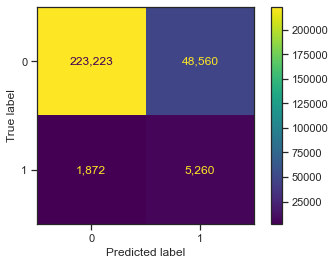

In [79]:
plot_confusion_matrix(
    gs_binary, train_values_subset, train_labels,
    values_format=",",
    cmap="viridis"
)

#### Plot confusion matrix with normalized values

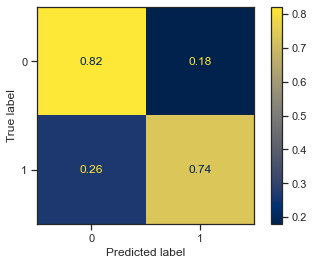

In [80]:
plot_confusion_matrix(
    gs_binary, train_values_subset, train_labels,
    normalize="true",
    values_format=".2f",
    cmap="cividis"
)

### Partial Dependence and Individual Conditional Expectation

Done in 97s


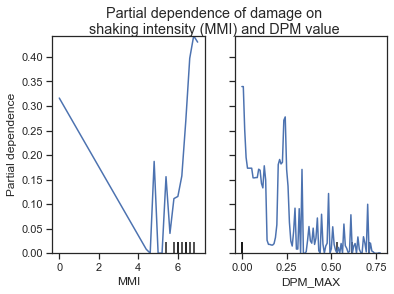

In [81]:
tic = time()
numeric_features = ["MMI", "DPM_MAX"]
display = plot_partial_dependence(
    gs_binary, X_train, numeric_features, target=3, n_cols=2
)
print(f"Done in {time() - tic:.0f}s")
display.figure_.suptitle(
    'Partial dependence of damage on\n'
    'shaking intensity (MMI) and DPM value'
)
display.figure_.subplots_adjust(hspace=0.5)

### Use the trained model to make predictions on the test set

In [82]:
y_pred = gs_binary.predict(X_test)

#### Display the confusion matrix for the predictions on the test set

In [83]:
confusion_matrix(y_test, y_pred)

array([[66581, 14968],
       [ 1096,  1030]])

#### Plot confusion matrix with absolute, non-normalized values

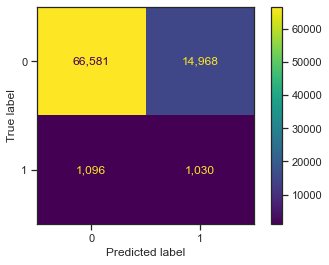

In [84]:
plot_confusion_matrix(
    gs_binary, X_test, y_test,
    values_format=",",
    cmap="viridis"
)

#### Plot confusion matrix with normalized values

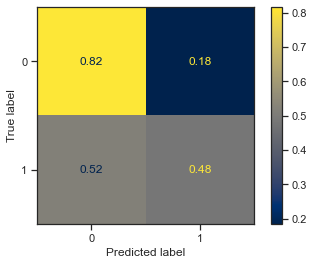

In [85]:
plot_confusion_matrix(
    gs_binary, X_test, y_test,
    normalize="true",
    values_format=".2f",
    cmap="cividis"
)

#### Print classification report for the predictions on the _test_ set

In [86]:
target_names = ["No Damage", "Damage"]
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

   No Damage       0.98      0.82      0.89     81549
      Damage       0.06      0.48      0.11      2126

    accuracy                           0.81     83675
   macro avg       0.52      0.65      0.50     83675
weighted avg       0.96      0.81      0.87     83675



#### Print balanced accuracy score for the predictions on the _test_ set

In [87]:
balanced_accuracy_score(y_test, y_pred)

0.6504659019508982